# Mean magnetization vs $\beta$

## Estimate the mean magnetization in the thermodynamic limit

The mean magnetization in the thermodynamic limit is given by the approximate equation

\begin{equation}
    \langle M \rangle \approx \langle \sigma_{i} \rangle \approx 2 \tanh{(\beta[2 \omega^{*} - h])} \tag{1}
\end{equation}

where $\omega^{*}$ is the fixed point for the recursive equation of the cavity parameters

\begin{equation}
    \omega_{i-1}^{(i)} = h + \frac{1}{2\beta} \log{\left( 
    \frac{
    \cosh{[\beta(\omega_{i-2}^{(i-1)} + 1)]}
    }{
    \cosh{[\beta(\omega_{i-2}^{(i-1)} - 1)]}
    }
    \right)}, \tag{2}
\end{equation}

and satisfies

\begin{equation}
    \omega^{*} = h + \frac{1}{2\beta} \log{\left( 
    \frac{
    \cosh{[\beta(\omega^{*} + 1)]}
    }{
    \cosh{[\beta(\omega^{*} - 1)]}
    }
    \right)}. \tag{3}
\end{equation}

Therefore, the main part of the problem consists on finding $\omega^{*}$.

## Algorithm: Finding the fixed point.

### Inputs
* (Inverse) Thermal energy $\beta$.
* External magnetic field strength $h$.
* Maximum number of iterations.
* Precision, i.e., number of decimal positions for which we track changes on consecutive values of $\omega^{(i)}_{i-1}$.

**Note:** Since any cavity distribution $P^{(2)}(\sigma_{1})$ will reach the fixed point relatively fast (see plot of first exercise), we can simply take $P^{(2)}(\sigma_{1} = \pm 1) = 1/2$, for which $\omega^{(2)}_{1} = 0$. 

### Ouput
* Fixed point $\omega^{*}$ at temperature $\beta$ and external magnetic field $h$.

### Procedure
1. Set an initial value $\omega = 0$
1. For i in 1:iterations
    1. Get a new value of $\omega$ using equation (2).
    1. Check the difference between the new and old values up to 'precision' digits.
        * If the difference is zero, stop the iteration and return the value of $\omega$.
        * If the difference is not zero, store the new value in place of the old and go on to the next iteration.
        
## Analytical expression

The mean magnetization in the thermodynamic limit is given by

\begin{equation}
    \langle M \rangle = \frac{\mathrm{e}^{2\beta}\sinh{\beta h}}{\sqrt{1 + (\mathrm{e}^{2\beta}\sinh{\beta h})^{2}}}. \tag{4}
\end{equation}

In [1]:
using Plots

# Recursive expression for cavity parameters
recursive_omega(ω, β, h) = h + (1/(2*β))*log(cosh(β*(ω+1))/cosh(β*(ω-1)))


function get_fixed_point(β, h; max_iter=500, precision=10)
    
    # Assuming uniform distribution for P(2)(σ1).
    ω = 0
    
    # Truncated value at the given precision.
    ω_trunc = trunc(ω, digits=precision)
    
    for i in 1:max_iter
        
        # Get new value and check 
        # difference at precision.
        ω2 = recursive_omega(ω, β, h)
        ω2_trunc = trunc(ω2, digits=precision)
                
        # Precision is achieved.
        ((ω2_trunc - ω_trunc) == 0) && break

        # Update values
        ω, ω_trunc = ω2, ω2_trunc
        
        # Let the user know if the desired precision was not achieved.
        (i == max_iter) && println("Precision not achieved.")
    end
    
    return ω
end


# Function to compute the mean magnetization.
function get_mean_magnetization(β, h; max_iter=500, precision=10)
    ω_fixed = get_fixed_point(β, h, max_iter=max_iter, precision=precision)
    M = tanh(β*(2. *ω_fixed - h)) 
    return M
end


# Analytical expression for the magnetization.
function analytical_magnetization(β, h)
    x = exp(2*β) * sinh(β*h)
    M = x/sqrt(1. + x^2)
    return M
end

analytical_magnetization (generic function with 1 method)

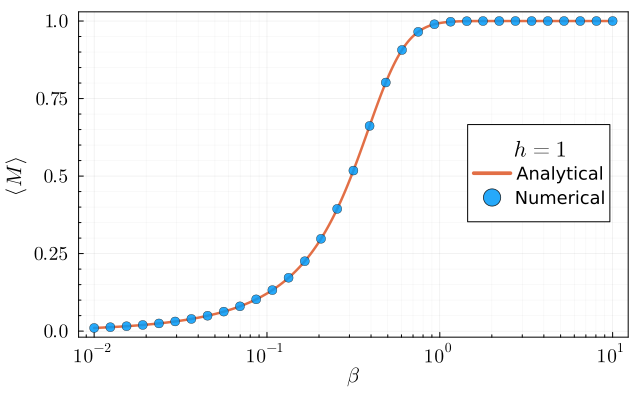

In [17]:
##############
# Parameters #
##############

h = 1  # External magnetic field strength.

# Inverse thermal energy limits.
β_min = 0.01  
β_max = 10


# Logarithmically equally-spaced β values to obtain M for 
# the numerical (apprx) and analytical (exact) solutions. 

# β_apprx = exp10.(sort(unique(vcat(range(log10(β_min), log10(0.1),length=7),
#                  range(log10(0.1), log10(1),length=11),
#                  range(log10(1), log10(β_max),length=7)))))

β_apprx = exp10.(range(log10(β_min), log10(β_max), length=33))
β_exact = exp10.(range(log10(β_min), log10(β_max), length=500))


##################
# Plot solutions #
##################

m_plot = plot(β_exact, analytical_magnetization.(β_exact, h), 
              label="Analytical", lw=2.5, lc=2)


scatter!(β_apprx, get_mean_magnetization.(β_apprx, h), 
         label="Numerical", markercolor=1, markersize=5, 
         markerstrokewidth=0.5, markeralpha=0.85)


# General plot attributes

h_label = h
(typeof(h) != Int) && (h_label = round(h, digits=2))

kw =(;
    xlabel="\$ \\beta \$",
    ylabel="\$ \\langle M \\, \\rangle \$",
    legendtitle="\$ h = $(h_label) \$",
    xminorgrid=true,
    yminorgrid=true,
#     xminorticks=10,
    yminorticks=5,
    xlabelfontsize=14,
    ylabelfontsize=14,  # Default value is 11.
    legendfontsize=12,
    legendtitlefontsize=15,
    legend=:right,
#     legend_columns=-1,
    tickfontsize=13,
    framestyle=:box,
    dpi=400,
    size=(640, 400),
    bottommargin=4Plots.mm,
    leftmargin=2Plots.mm,
)


xticks_range = [round(10. ^i, digits=abs(i)) 
                for i in -3:2 if β_min <= 10. ^i <= β_max]
xticks_labs = ["\$ 10^{$(i)} \$" 
                for i in -3:2 if β_min <= 10. ^i <= β_max]

yticks_range = 0:0.25:1
yticks_labs = ["\$ $(m) \$" for m ∈ yticks_range]

plot!(xticks=(xticks_range, xticks_labs),
      yticks=(yticks_range, yticks_labs),)

plot!(xaxis=:log10)
plot!(;kw...)

# savefig(m_plot, "Figures/magnetization_plot_h_$(h_label).png")